Long First Point                    -122.442776
Lat First Point                       43.720257
Region First Point     USGS_13_n44w123_20231102
Long Second Point                   -122.427769
Lat Second Point                      43.724246
Region Second Point    USGS_13_n44w123_20231102
Name: 0, dtype: object


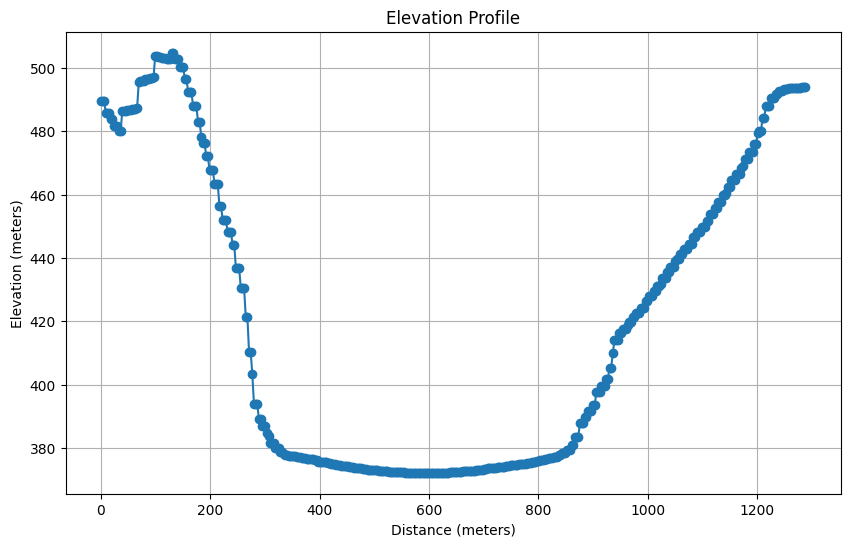

Long First Point                    -122.506075
Lat First Point                       43.738337
Region First Point     USGS_13_n44w123_20231102
Long Second Point                    -122.50716
Lat Second Point                      43.748788
Region Second Point    USGS_13_n44w123_20231102
Name: 1, dtype: object


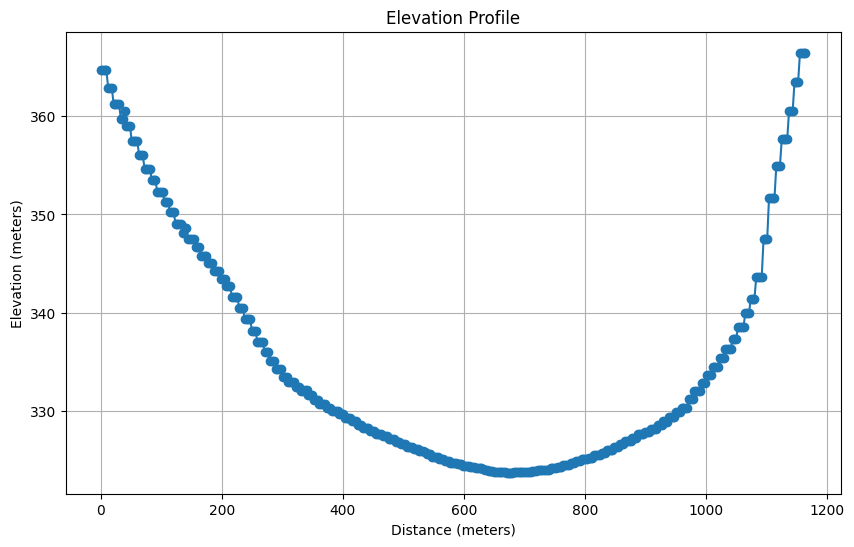

Long First Point                    -122.540111
Lat First Point                       43.782876
Region First Point     USGS_13_n44w123_20231102
Long Second Point                   -122.532021
Lat Second Point                       43.78942
Region Second Point    USGS_13_n44w123_20231102
Name: 2, dtype: object


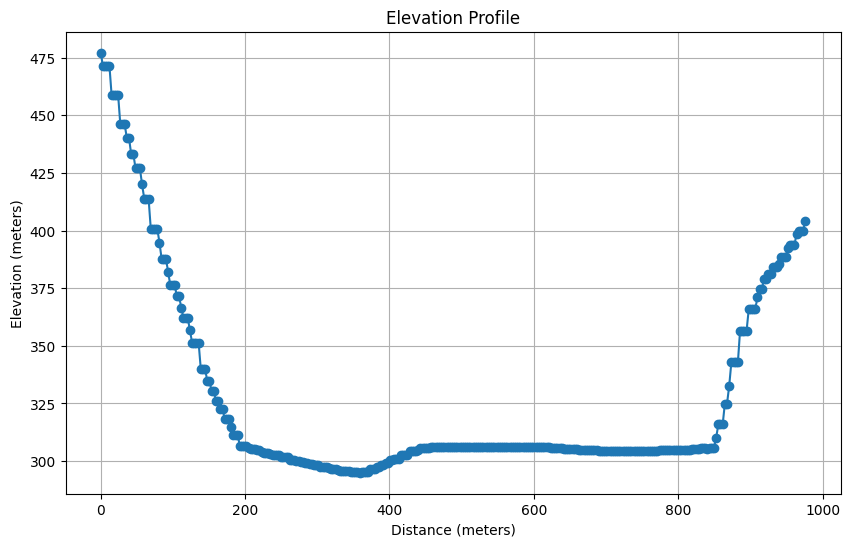

Long First Point                    -122.638502
Lat First Point                       43.847478
Region First Point     USGS_13_n44w123_20231102
Long Second Point                   -122.636241
Lat Second Point                      43.855212
Region Second Point    USGS_13_n44w123_20231102
Name: 3, dtype: object


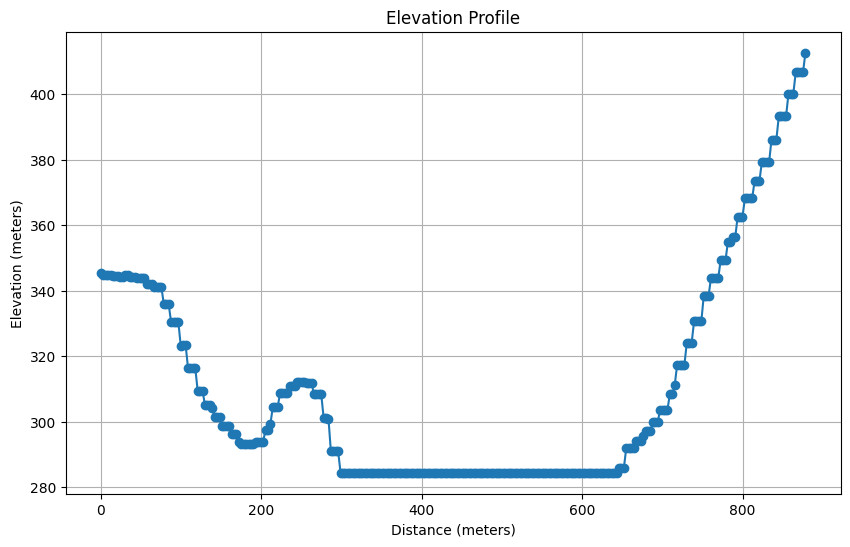

Long First Point                    -122.759153
Lat First Point                       43.907352
Region First Point     USGS_13_n44w123_20231102
Long Second Point                   -122.760905
Lat Second Point                      43.917701
Region Second Point    USGS_13_n44w123_20231102
Name: 4, dtype: object


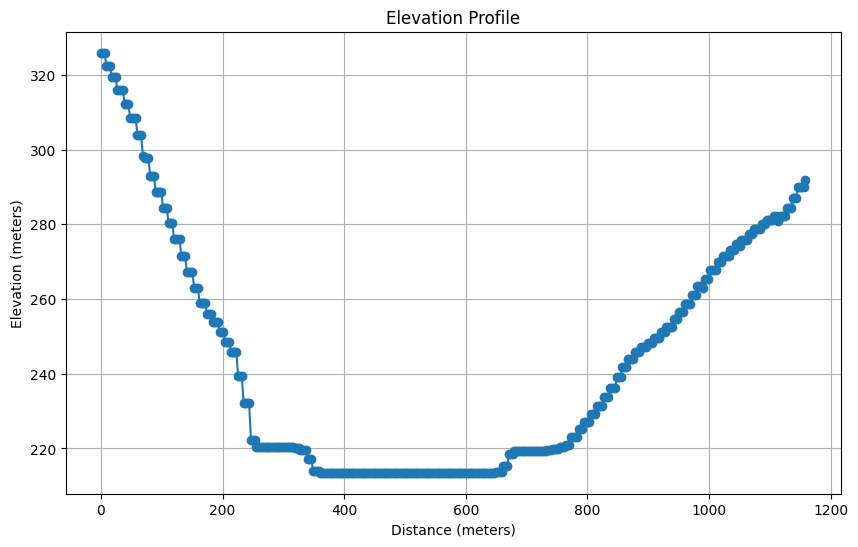

Long First Point                     -122.81046
Lat First Point                       43.907203
Region First Point     USGS_13_n44w123_20231102
Long Second Point                   -122.806148
Lat Second Point                      43.931741
Region Second Point    USGS_13_n44w123_20231102
Name: 5, dtype: object


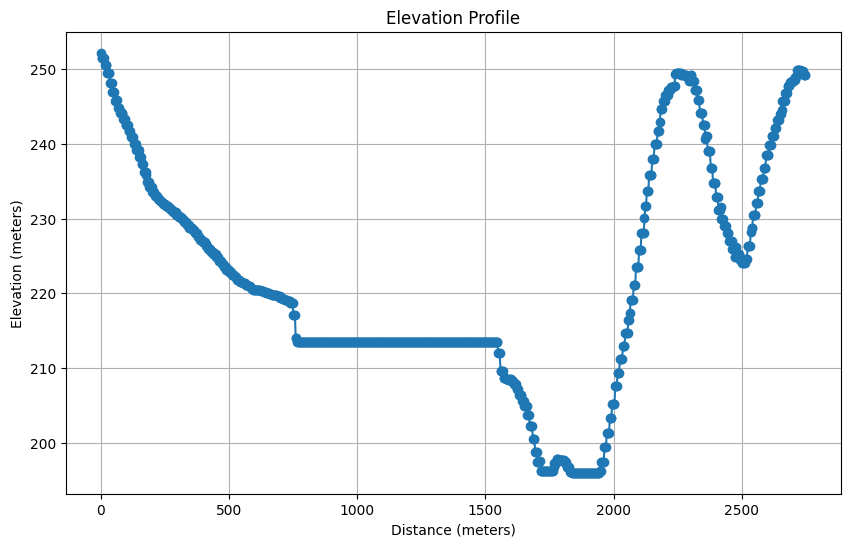

Long First Point                    -122.843475
Lat First Point                       43.928767
Region First Point     USGS_13_n44w123_20231102
Long Second Point                   -122.822952
Lat Second Point                      43.942449
Region Second Point    USGS_13_n44w123_20231102
Name: 6, dtype: object


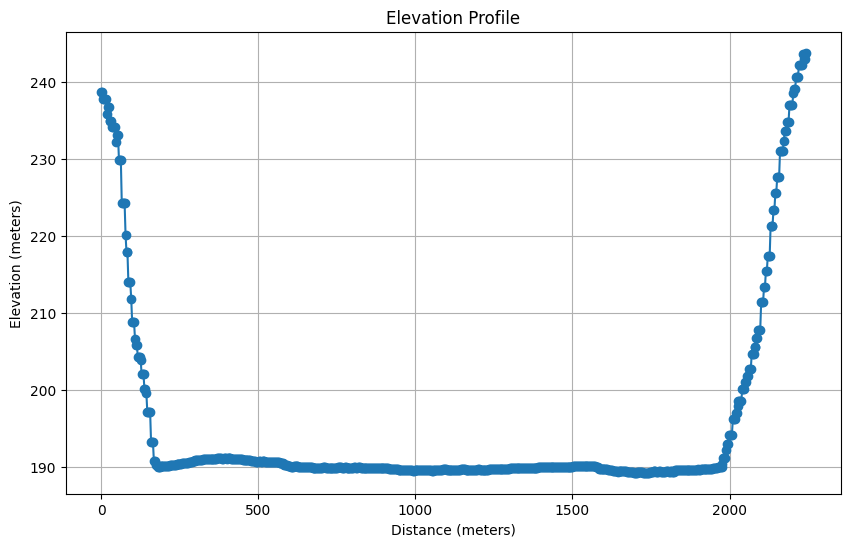

Long First Point                    -122.854034
Lat First Point                       43.934418
Region First Point     USGS_13_n44w123_20231102
Long Second Point                   -122.847193
Lat Second Point                      43.953454
Region Second Point    USGS_13_n44w123_20231102
Name: 7, dtype: object


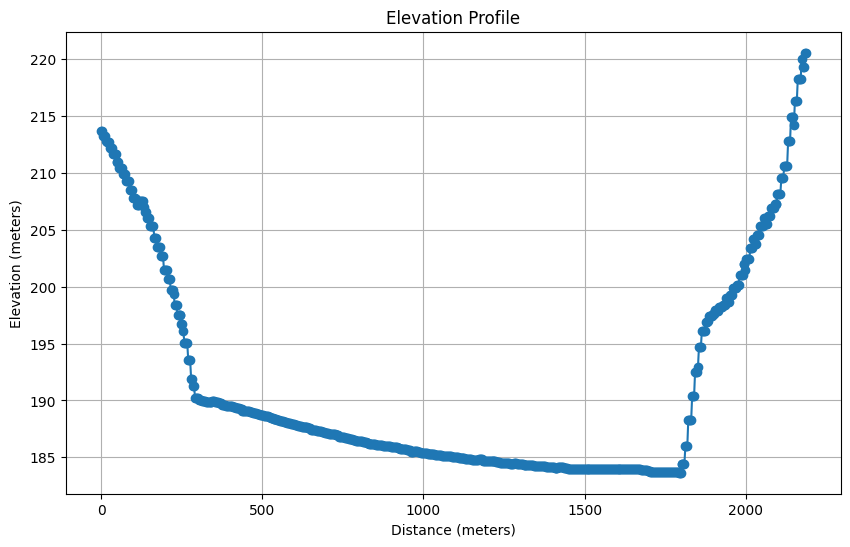

Long First Point                    -122.885789
Lat First Point                       43.945698
Region First Point     USGS_13_n44w123_20231102
Long Second Point                   -122.851357
Lat Second Point                      43.971746
Region Second Point    USGS_13_n44w123_20231102
Name: 8, dtype: object


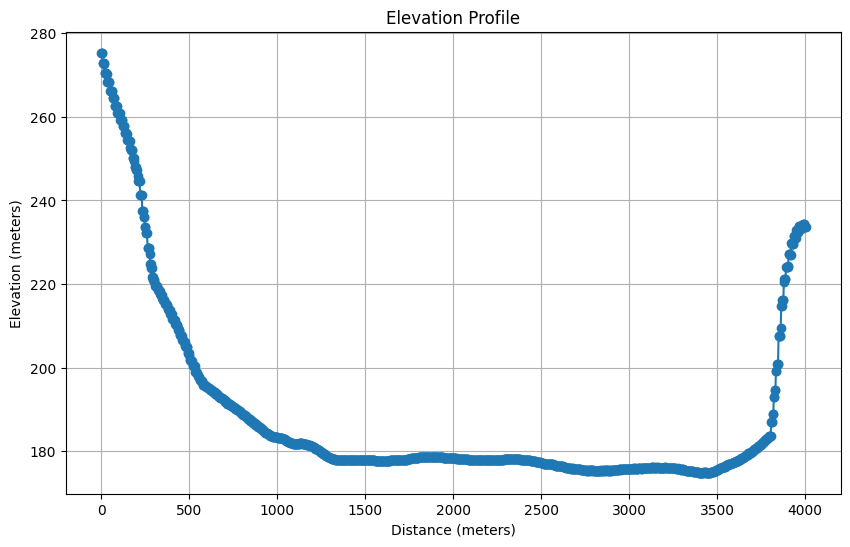

Long First Point                    -122.902825
Lat First Point                       43.946602
Region First Point     USGS_13_n44w123_20231102
Long Second Point                   -122.875747
Lat Second Point                      43.982007
Region Second Point    USGS_13_n44w123_20231102
Name: 9, dtype: object


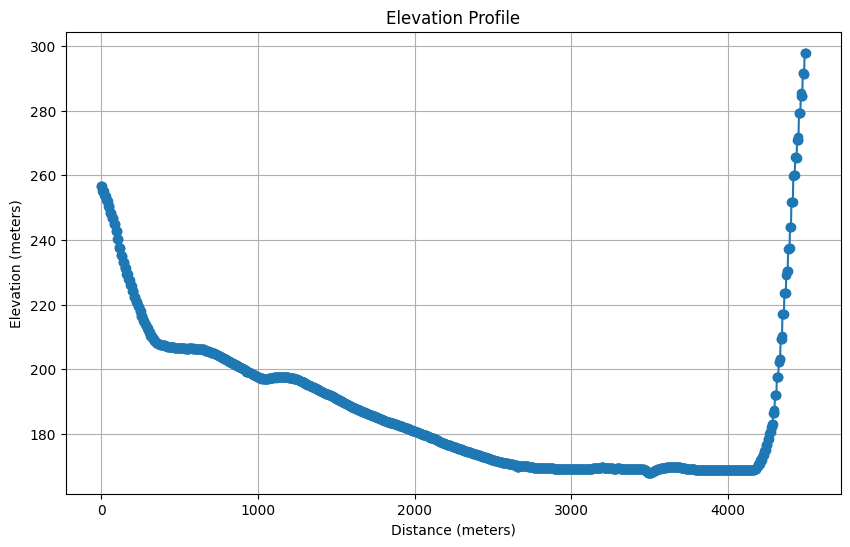

In [2]:
import pandas as pd
import numpy as np
import rasterio
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import os
import time  # for sleep in case of PermissionError

BASE_PATH = "G:/Big_Data_Preprocessing/Water/Cross_Section"

def calculate_distances(path):
    return np.cumsum(
        [0] + [geodesic(path[i], path[i + 1]).meters for i in range(len(path) - 1)]
    )

def generate_path(start, end, num_points):
    latitudes = np.linspace(start[0], end[0], num_points)
    longitudes = np.linspace(start[1], end[1], num_points)
    path = list(zip(longitudes, latitudes))
    return path

data = pd.read_excel(f'../Data/Excel/MCmiddle_final.xlsx', index_col=0)
i = 0
os.makedirs('../Output_MCMiddleFinal/Image', exist_ok=True)
os.makedirs('../Output_MCMiddleFinal/Excel', exist_ok=True)

while i < int(data.shape[0]):
    print(data.iloc[i])
    Long_First_Point = float(data.iloc[i]["Long First Point"])
    Lat_First_Point = float(data.iloc[i]["Lat First Point"])
    Region_First_Point = data.iloc[i]["Region First Point"]
    Long_Second_Point = float(data.iloc[i]["Long Second Point"])
    Lat_Second_Point = float(data.iloc[i]["Lat Second Point"])
    Region_Second_Point = data.iloc[i]["Region Second Point"]
    
    First_Point = (Lat_First_Point, Long_First_Point)
    Second_Point = (Lat_Second_Point, Long_Second_Point)
    Distance = geodesic(First_Point, Second_Point).meters
    
    # Generate path
    path = generate_path(First_Point, Second_Point, int(Distance / 3))
    
    # Read raster
    srtm_file = f'../Data/GeoTIFF/{Region_First_Point}.tif'
    elevations = []
    with rasterio.open(srtm_file) as dataset:
        for attempt in range(3):
            try:
                dataset_read = dataset.read(1)
                break
            except:
                print("Error")
        for lon, lat in path:
            row, col = dataset.index(lon, lat)
            elevations.append(dataset_read[row, col])
    
    distances_segments = [
        geodesic((path[j][1], path[j][0]), (path[j+1][1], path[j+1][0])).meters
        for j in range(len(path) - 1)
    ]
    total_distance = sum(distances_segments)
    
    fig = plt.figure(figsize=(10, 6))
    try:
        plt.plot(np.cumsum([0] + distances_segments), elevations, marker='o')
    except:
        # If there's an error plotting, just skip this iteration
        i += 1
        continue
    
    plt.xlabel('Distance (meters)')
    plt.ylabel('Elevation (meters)')
    plt.title('Elevation Profile')
    plt.grid(True)
    plt.show()
    
    name = i
    # ------------------------------
    # Save figure with retry logic
    # ------------------------------
    for attempt in range(3):
        try:
            fig.savefig(f'../Output_MCMiddleFinal/Image/ID_{name+1}.png')
            break
        except PermissionError:
            print("PermissionError while saving figure. Retrying in 1 second...")
            time.sleep(1)
    
    # Create DataFrame for Excel
    df_out = pd.DataFrame(columns=["Depth", "Distance"])
    csum_distances = np.cumsum([0] + distances_segments)
    for j in range(len(elevations)):
        elevation = elevations[j]
        distance = csum_distances[j]
        df_out.loc[j] = [elevation, distance]
    
    # ------------------------------
    # Save Excel with retry logic
    # ------------------------------
    for attempt in range(3):
        try:
            df_out.to_excel(f'../Output_MCMiddleFinal/Excel/ID_{name+1}.xlsx')
            break
        except PermissionError:
            print("PermissionError while saving Excel. Retrying in 1 second...")
            time.sleep(1)
    
    i += 1


Long First Point                    -122.943382
Lat First Point                       43.951149
Region First Point     USGS_13_n44w123_20231102
Long Second Point                   -122.891395
Lat Second Point                        44.0174
Region Second Point    USGS_13_n45w123_20220426
Name: 0, dtype: object


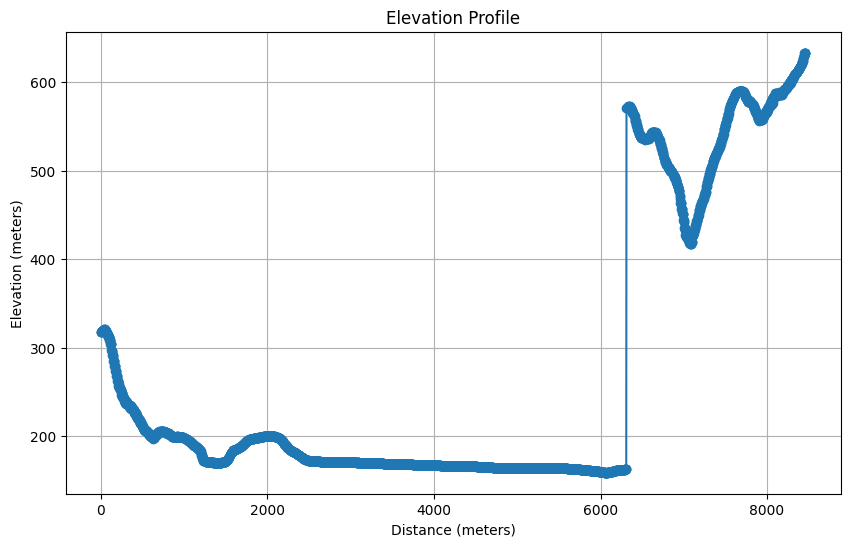

In [6]:
import pandas as pd
import numpy as np
import rasterio
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import time  # for sleep in case of PermissionError

BASE_PATH = "G:/Big_Data_Preprocessing/Water/Cross_Section"

def calculate_distances(path):
    return np.cumsum(
        [0] + [geodesic(path[i], path[i + 1]).meters for i in range(len(path) - 1)]
    )

def generate_path(start, end, num_points):
    latitudes = np.linspace(start[0], end[0], num_points)
    longitudes = np.linspace(start[1], end[1], num_points)
    path = list(zip(longitudes, latitudes))
    return path

data = pd.read_excel(f'../Data/Excel/MCmid_haluu.xlsx')
i = 0

while i < int(data.shape[0]):
    print(data.iloc[i])
    Long_First_Point = float(data.iloc[i]["Long First Point"])
    Lat_First_Point = float(data.iloc[i]["Lat First Point"])
    Region_First_Point = data.iloc[i]["Region First Point"]
    Long_Second_Point = float(data.iloc[i]["Long Second Point"])
    Lat_Second_Point = float(data.iloc[i]["Lat Second Point"])
    Region_Second_Point = data.iloc[i]["Region Second Point"]
    
    First_Point = (Lat_First_Point, Long_First_Point)
    Second_Point = (Lat_Second_Point, Long_Second_Point)
    Distance = geodesic(First_Point, Second_Point).meters
    
    # Generate path
    path = generate_path(First_Point, Second_Point, int(Distance / 3))
    elevations = []
    # Read raster
    if Region_First_Point == Region_Second_Point:
        srtm_file = f'../Data/GeoTIFF/{Region_First_Point}.tif'
        with rasterio.open(srtm_file) as dataset:
            for attempt in range(3):
                try:
                    dataset_read = dataset.read(1)
                    break
                except:
                    print("Error")
            for lon, lat in path:
                row, col = dataset.index(lon, lat)
                elevations.append(dataset_read[row, col])
    else:
        srtm_file_1 = f'../Data/GeoTIFF/{Region_First_Point}.tif'
        srtm_file_2 = f'../Data/GeoTIFF/{Region_Second_Point}.tif'
        with rasterio.open(srtm_file_1) as dataset_1:
            for attempt in range(3):
                try:
                    dataset_read_1 = dataset_1.read(1)
                    break
                except:
                    print("Error")
        with rasterio.open(srtm_file_2) as dataset_2:
            for attempt in range(3):
                try:
                    dataset_read_2 = dataset_2.read(1)
                    break
                except:
                    print("Error")
        for lon, lat in path:
            try:
                row, col = dataset_1.index(lon, lat)
                elevations.append(dataset_read_1[row, col])
            except:
                row, col = dataset_2.index(lon, lat)
                elevations.append(dataset_read_2[row, col])
    
    distances_segments = [
        geodesic((path[j][1], path[j][0]), (path[j+1][1], path[j+1][0])).meters
        for j in range(len(path) - 1)
    ]
    total_distance = sum(distances_segments)
    
    fig = plt.figure(figsize=(10, 6))
    try:
        plt.plot(np.cumsum([0] + distances_segments), elevations, marker='o')
    except:
        # If there's an error plotting, just skip this iteration
        i += 1
        continue
    
    plt.xlabel('Distance (meters)')
    plt.ylabel('Elevation (meters)')
    plt.title('Elevation Profile')
    plt.grid(True)
    plt.show()
    
    name = i
    # ------------------------------
    # Save figure with retry logic
    # ------------------------------
    for attempt in range(3):
        try:
            fig.savefig(f'../Output_MCMidHaLuu/Image/ID_{name+1}.png')
            break
        except PermissionError:
            print("PermissionError while saving figure. Retrying in 1 second...")
            time.sleep(1)
    
    # Create DataFrame for Excel
    df_out = pd.DataFrame(columns=["Depth", "Distance"])
    csum_distances = np.cumsum([0] + distances_segments)
    for j in range(len(elevations)):
        elevation = elevations[j]
        distance = csum_distances[j]
        df_out.loc[j] = [elevation, distance]
    
    # ------------------------------
    # Save Excel with retry logic
    # ------------------------------
    for attempt in range(3):
        try:
            df_out.to_excel(f'../Output_MCMidHaLuu/Excel/ID_{name+1}.xlsx')
            break
        except PermissionError:
            print("PermissionError while saving Excel. Retrying in 1 second...")
            time.sleep(1)
    
    i += 1
